# PCA applied on PBMC 10X 4k Dataset

This notebooks contains : 
- the loading and preprocessing of the PBMC 4k dataset 
- the fine tuning of the PCA using train and val set
- final evaluation on the test set

## Import useful modules

In [1]:
!pip install scanpy
!pip install keras
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip3 install igraph
!pip3 install leidenalg
!pip install os
!pip install csv
!pip install random

In [2]:
from keras import layers
from keras.models import load_model, Model
from keras import backend as K
import numpy as np
import scanpy as sc
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from layers import ConstantDispersionLayer, SliceLayer, ColWiseMultLayer
import keras
from keras.layers import Layer
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics.pairwise import euclidean_distances
from scipy.optimize import linear_sum_assignment as linear_assignment
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import h5py

In [3]:
tf.__version__

'2.15.0'

In [4]:
keras.__version__

'2.15.0'

## Preprocessing

### Load dataset

Import dataset PBMC and check the data

In [5]:
filename="./dataset/10X_PBMC.h5"
with h5py.File(filename, 'r') as f :
    data_X=f['X'][:]
    data_Y=f['Y'][:]
    df_X=pd.DataFrame(data_X)
    df_Y=pd.DataFrame(data_Y)
    
df_X

,human1_lib1.final_cell_0001,human1_lib1.final_cell_0002,human1_lib1.final_cell_0003,human1_lib1.final_cell_0004,human1_lib1.final_cell_0005,human1_lib1.final_cell_0006,human1_lib1.final_cell_0007,human1_lib1.final_cell_0008,human1_lib1.final_cell_0009,human1_lib1.final_cell_0010,...,human4_lib3.final_cell_0692,human4_lib3.final_cell_0693,human4_lib3.final_cell_0694,human4_lib3.final_cell_0695,human4_lib3.final_cell_0696,human4_lib3.final_cell_0697,human4_lib3.final_cell_0698,human4_lib3.final_cell_0699,human4_lib3.final_cell_0700,human4_lib3.final_cell_0701
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,4,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A4GALT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,0,1,0,1,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
ZYX,2,4,0,3,1,1,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
ZZEF1,0,0,0,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
ZZZ3,0,1,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [6]:
df_Y.columns=['label']
df_Y["label"]=df_Y['label'].astype(str)
df_Y

,donor,label
human1_lib1.final_cell_0001,GSM2230757,acinar
human1_lib1.final_cell_0002,GSM2230757,acinar
human1_lib1.final_cell_0003,GSM2230757,acinar
human1_lib1.final_cell_0004,GSM2230757,acinar
human1_lib1.final_cell_0005,GSM2230757,acinar
...,...,...
human4_lib3.final_cell_0697,GSM2230760,activated_stellate
human4_lib3.final_cell_0698,GSM2230760,alpha
human4_lib3.final_cell_0699,GSM2230760,beta
human4_lib3.final_cell_0700,GSM2230760,beta


In [7]:
df_Y["label"].value_counts()

AnnData object with n_obs × n_vars = 8569 × 20125

In [8]:
data_ann=sc.AnnData(df_X)
data_ann

In [ ]:
data_ann.obs=df_Y

### Filter data

On filtre les données de manière peu stricte

In [9]:
sc.pp.filter_cells(data_ann, min_genes=1)
sc.pp.filter_genes(data_ann, min_cells=1)

In [10]:
data_ann.raw = data_ann.copy()

In [11]:
data_ann

AnnData object with n_obs × n_vars = 8569 × 17499
    obs: 'label', 'n_genes'
    var: 'n_cells'

### Normalize and scale

In [12]:
#normalize
sc.pp.normalize_total(data_ann)

#compute size factor
data_ann.obs['size_factors'] = data_ann.obs.n_genes / np.median(data_ann.obs.n_genes)
#data_ann.obs['size_factors'] = 1.0

#log transform
sc.pp.log1p(data_ann)

Features selection : selection of high variable genes

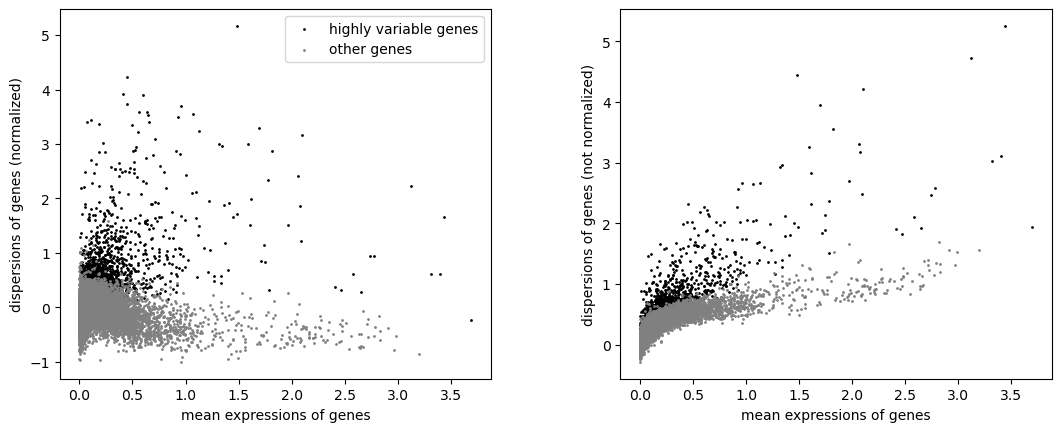

In [13]:
sc.pp.highly_variable_genes(data_ann, n_top_genes=2000, batch_key="label")
sc.pl.highly_variable_genes(data_ann)

In [14]:
#scale the data
sc.pp.scale(data_ann)

### Explore the result

In [15]:
data_ann.X

array([[-0.06469017,  1.5632517 , -0.1655249 , ..., -0.37393612,
        -0.3080396 ,  0.3184867 ],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
         0.37840593, -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       ...,
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617]], dtype=float32)

In [16]:
data_ann.n_vars

17499

In [17]:
data_ann.X

array([[-0.06469017,  1.5632517 , -0.1655249 , ..., -0.37393612,
        -0.3080396 ,  0.3184867 ],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
         0.37840593, -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       ...,
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617],
       [-0.06469017, -0.40407085, -0.1655249 , ..., -0.37393612,
        -0.3080396 , -0.35446617]], dtype=float32)

In [18]:
data_ann.var

,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,mean,std
A1BG,42,False,0.011018,-0.025517,-0.574290,1,False,0.003199,0.049455
A1CF,1408,False,0.140704,0.230606,-0.024027,1,False,0.132453,0.327797
A2M,273,False,0.162812,0.371500,0.196539,3,False,0.029914,0.180720
A4GALT,444,False,0.134773,0.333580,0.060687,3,False,0.043716,0.203291
AAAS,1216,True,0.183781,0.576148,0.473154,6,False,0.104913,0.285008
...,...,...,...,...,...,...,...,...,...
ZYG11B,1394,False,0.192391,0.371347,-0.082705,1,False,0.119749,0.299532
ZYX,2691,False,0.572281,0.582603,-0.147203,2,False,0.289623,0.489316
ZZEF1,1225,False,0.144169,0.421400,0.217033,2,False,0.106196,0.283994
ZZZ3,872,False,0.120500,0.381103,0.083912,1,False,0.074865,0.243036


In [19]:
data_ann.obs

,label,n_genes,size_factors
human1_lib1.final_cell_0001,acinar,3526,1.909042
human1_lib1.final_cell_0002,acinar,4201,2.274499
human1_lib1.final_cell_0003,acinar,2119,1.147266
human1_lib1.final_cell_0004,acinar,2956,1.600433
human1_lib1.final_cell_0005,acinar,2715,1.469951
...,...,...,...
human4_lib3.final_cell_0697,activated_stellate,1055,0.571197
human4_lib3.final_cell_0698,alpha,1007,0.545208
human4_lib3.final_cell_0699,beta,942,0.510016
human4_lib3.final_cell_0700,beta,1031,0.558202


In [20]:
data_ann.raw.X

array([[0, 4, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Get only the data corresponding to the high variable genes

In [21]:
# get the preprocessed count matrix of the high variables genes only
highly_variable_genes = data_ann.var[data_ann.var['highly_variable']].index.tolist()
count_data_hvg = data_ann[:, highly_variable_genes].X
count_data_hvg=count_data_hvg.toarray()
count_data_hvg

array([[-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 ,  0.3184867 ],
       [-0.36810586,  0.04432194, -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       [-0.36810586,  0.3338873 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       ...,
       [-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       [-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617],
       [-0.36810586, -0.4597898 , -0.04802068, ..., -0.2182465 ,
        -0.1417951 , -0.35446617]], dtype=float32)

In [22]:
#get the raw matrix of the high variable genes only
raw_count_hvg=data_ann.raw[:,highly_variable_genes].X

## Split data

In [23]:
def split(x_counts, y):
    """
    Split the data into train, val and test set
    
    Inputs :
        x_counts : the input count matrix
        y : the true labels
        
    Outputs :
        x_train : the input count matrix train
        x_val : the input count matrix val
        x_test : the input count matrix test
        y_train : the true labels train
        y_val : the true labels val
        y_test : the true labels test
    """
    #get the indices of the train, val and test cells
    train_idx, temp_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.3, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
    
    #split the data
    x_train=x_counts[train_idx]
    x_val=x_counts[val_idx]
    x_test=x_counts[test_idx]
    y_train=y[train_idx]
    y_val=y[val_idx]
    y_test=y[test_idx]
    
    #look at the size
    print("Size of train set : ", x_train.shape)
    print("Size of val set : ", x_val.shape)
    print("Size of test set : ", x_test.shape)
    return x_train, x_val, x_test, y_train, y_val, y_test

In [24]:
x_train, x_val, x_test, y_train, y_val, y_test = split(count_data_hvg, data_ann.obs['label'])

Size of train set :  (5998, 2000)
Size of val set :  (1285, 2000)
Size of test set :  (1286, 2000)


In [25]:
#create anndata for train set
adata_train = sc.AnnData(x_train)
obs_train=pd.DataFrame({'label': y_train})
adata_train.obs=obs_train
adata_train

AnnData object with n_obs × n_vars = 5998 × 2000
    obs: 'label'

In [26]:
#create anndata for test set
adata_test = sc.AnnData(x_test)
obs_test=pd.DataFrame({'label': y_test})
adata_test.obs=obs_test
adata_test

AnnData object with n_obs × n_vars = 1286 × 2000
    obs: 'label'

In [27]:
#create anndata for val set
adata_val = sc.AnnData(x_val)
obs_val=pd.DataFrame({'label': y_val})
adata_val.obs=obs_val
adata_val

AnnData object with n_obs × n_vars = 1285 × 2000
    obs: 'label'

## Fine tuning

In [28]:
sc.tl.pca(adata_train)

<BarContainer object of 50 artists>

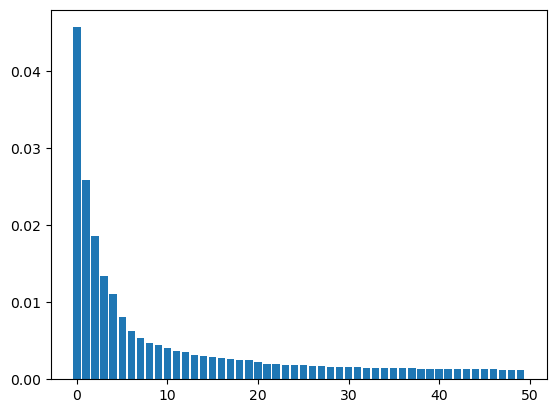

In [29]:
dim=[i for i in range (50)]
plt.bar(dim, adata_train.uns['pca']['variance_ratio'])

In [30]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = np.asarray(y_true)
   
    y_pred = np.asarray(y_pred)
    
    #Make sure it's an array of str
    y_true= y_true.astype(str)
    y_pred = y_pred.astype(str)
    
    # find unique labels
    labels = np.unique(np.concatenate((y_true, y_pred)))
    n_labels = len(labels)

    # Build the confusion matrix (cost matrix)
    cost_matrix = np.zeros((n_labels, n_labels), dtype=int)
    for i, label_true in enumerate(labels):
        for j, label_pred in enumerate(labels):
            cost_matrix[i, j] = np.sum((y_true == label_true) & (y_pred == label_pred))

    #solve the optimal bipartite correspondance problem
    row_ind, col_ind = linear_assignment(cost_matrix.max() - cost_matrix)

    # Compute the accuracy
    accuracy = np.sum([cost_matrix[i, j] for i, j in zip(row_ind, col_ind)]) / y_true.size

    return accuracy

In [31]:
def auto_leiden( adata_latent, plot=False):
     """
    Apply Leiden clustering on the data to maximise the sum of the metrics
    
    Inputs :
        adata_latent : data after pca projection
        plot (bool) : if True show some plots, none otherwise
    
    Outputs :
        predict : the clusters assignments
        n_clusters (int) : the number of clusters
        cluster_centers : the clusters centers 
    """
    y=adata_latent.obs["label"]
    
    #compute neigbors and UMAP 
    sc.pp.neighbors(adata_latent, use_rep='X_pca')
    sc.tl.umap(adata_latent)
    list_ari=[]
    list_nmi=[]
    list_ca=[]
    x=[]
    
    #search for the best resolution
    for i in range (1,10):
        sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/100)
        predict_cluster=adata_latent.obs["leiden"]
        list_ari.append(adjusted_rand_score(y, predict_cluster))
        list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
        list_ca.append(cluster_acc(y, predict_cluster))
        x.append(i/100)
    for i in range (1,11):
        sc.tl.leiden(adata_latent, key_added="leiden", resolution=i/10)
        predict_cluster=adata_latent.obs["leiden"]
        list_ari.append(adjusted_rand_score(y, predict_cluster))
        list_nmi.append(normalized_mutual_info_score(y, predict_cluster))
        list_ca.append(cluster_acc(y, predict_cluster))
        x.append(i/10)
    #select the best resolution value
    somme_metriques = [x + y +z for x, y, z in zip(list_ari, list_nmi, list_ca)]
    res_max=x[somme_metriques.index(max(somme_metriques))]
    print("La résolution est de : ", res_max)
    
    #compute for the best resolution
    sc.tl.leiden(adata_latent, key_added="leiden_res_%.4f" % (res_max), resolution=res_max)
    predict=adata_latent.obs["leiden_res_%.4f" % (res_max)]
    
    
    #compute cluster center for initialization
    init_pred=np.asarray(predict,dtype=int)
    features=pd.DataFrame(adata_latent.obsm['X_pca'],index=np.arange(0,adata_latent.shape[0]))
    Group=pd.Series(init_pred,index=np.arange(0,adata_latent.shape[0]),name="Group")
    Mergefeature=pd.concat([features,Group],axis=1)
    cluster_centers=np.asarray(Mergefeature.groupby("Group").mean())
    n_clusters=len(np.unique(init_pred))
    
    #set of plot if required
    if plot==True:
        sc.pl.umap(adata_latent, color='label')
        plt.plot(x,list_ari)
        plt.xlabel("nombre de clusters")
        plt.ylabel("ARI")
        plt.plot(x,list_nmi)
        plt.xlabel("nombre de clusters")
        plt.ylabel("NMI")
        sc.pl.umap(adata_latent, color="leiden_res_%.4f" % (res_max))
        ari = adjusted_rand_score(y, predict)
        print("Indice de Rand ajusté (ARI) :", ari)
        nmi = normalized_mutual_info_score(y, predict)
        print("Normalized mutual info (NMI) :", nmi)
        ca=cluster_acc(y, predict)
        print("Cluster Accuracy (CA) :", ca)
        plt.plot()
        #crosstab = pd.crosstab(predict,y)
        #sns.heatmap(crosstab, annot=True, cmap='Blues')
        #plt.ylabel('Clusters prédits')
        #plt.xlabel('Annotations réelles')
        #plt.title('Matrice de confusion')
        #plt.show()
    return predict, n_clusters, cluster_centers

def auto_kmeans( adata_latent, n="auto", plot=False):
    """
    Apply K-means clustering on the data to maximise the sum of the metrics
    
    Inputs :
        adata_latent : data after pca projection
        n : if auto, look for the best number of clusters otherwise use the n value given
        plot (bool) : if True show some plots, none otherwise
    
    Outputs :
        y_pred : clusters assignments from K-means clustering
        n (int) : the number of clusters 
        kmeans.cluster_centers_ : clusters centers
    """
    y=adata_latent.obs["label"]
    X_pca = adata_latent.obsm['X_pca']
    ari=[]
    nmi=[]
    ca=[]
    x=[]
    if n=="auto":
        #apply K-means for 1 to 20 clusters
        for n in range (1,20):
            kmeans = KMeans(n_clusters=n, random_state=0, n_init=30).fit(X_pca) 
            y_pred=kmeans.labels_.astype(str)
            ari.append(adjusted_rand_score(y, y_pred))
            nmi.append(normalized_mutual_info_score(y, y_pred))
            ca.append(cluster_acc(y, y_pred))
            x.append(n)
        #choose the number of clusters that maximize the sum of the metrics
        somme_metriques = [x + y + z for x, y, z in zip(ari, nmi, ca)]
        n_max=(somme_metriques.index(max(somme_metriques))+1)
    else: 
        n_max=n
        
    #compute for the selected value of n     
    kmeans = KMeans(n_clusters=n_max, random_state=0, n_init=30).fit(X_pca) 
    y_pred=kmeans.labels_.astype(str)
    
    #display some plots if needed
    if plot==True:
        adata_latent.obs["kmeans"]=y_pred
        sc.pl.pca(adata_train,color=["label"],dimensions=[(0, 1)])
        sc.pl.pca(adata_train,color=["kmeans"],dimensions=[(0, 1)])
        plt.plot(x,ari)
        plt.plot(x,nmi)
        plt.plot(x,ca)
        plt.xlabel("nombre de clusters")
        plt.ylabel("Score")
        plt.legend(labels=["ARI", "NMI", "CA"])
        plt.plot()
    ari = adjusted_rand_score(y, y_pred)
    print("Indice de Rand ajusté (ARI) :", ari)
    nmi = normalized_mutual_info_score(y, y_pred)
    print("Normalized mutual info (NMI) :", nmi)
    ca=cluster_acc(y, y_pred)
    print("Clustering accuracy (CA) :", ca)
        
    return y_pred, n, kmeans

Explore the metrics and the clustering method according to the number of principal components 

In [32]:
# Define the range of number of components
range_n_components = list(range(1, 51))

#Initialize lists to save results
silhouette_scores_kmeans = []
ari_score_kmeans=[]
nmi_score_kmeans=[]
ca_score_kmeans=[]
silhouette_scores_leiden = []
ari_score_leiden=[]
nmi_score_leiden=[]
ca_score_leiden=[]


for n in range_n_components:
    # Apply PCA
    sc.tl.pca(adata_train, n_comps=n, use_highly_variable=False)
    X_pca = adata_train.obsm['X_pca']

    # Apply K-means clustering
    y_pred, n_kmeans, kmeans = auto_kmeans(adata_train, n="auto", plot=False)    
    adata_val.obsm['X_pca'] = adata_val.X @ adata_train.varm['PCs']
    X_pca_val=adata_val.obsm['X_pca']
    adata_val.obs['kmeans'] = kmeans.predict(X_pca_val.astype('float32'))
    clusters=adata_val.obs['kmeans']
    
    # Compute silhouette score, ARI,NMI and CA
    score = silhouette_score(X_pca_val, clusters)
    silhouette_scores_kmeans.append(score)
    ari_score_kmeans.append(adjusted_rand_score(adata_val.obs['label'], clusters))
    nmi_score_kmeans.append(normalized_mutual_info_score(adata_val.obs['label'], clusters))
    ca_score_kmeans.append(cluster_acc(adata_val.obs['label'], clusters))
    print(f'Nombre de composantes: {n}, Score de silhouette: {score}')
    
    # Apply Leiden clustering 
    predict, n_clusters, cluster_centers = auto_leiden(adata_train, plot=False)
    adata_val.obsm['X_pca'] = adata_val.X @ adata_train.varm['PCs']
    X_val_pca = adata_val.obsm['X_pca']
    distances = euclidean_distances(X_val_pca, cluster_centers)
    clusters = np.argmin(distances, axis=1)
    adata_val.obs['leiden']=clusters
    
    # Compute silhouette score, ARI,NMI and CA
    score = silhouette_score(X_val_pca, clusters)
    silhouette_scores_leiden.append(score)
    ari_score_leiden.append(adjusted_rand_score(adata_val.obs['label'], clusters))
    nmi_score_leiden.append(normalized_mutual_info_score(adata_val.obs['label'], clusters))
    ca_score_leiden.append(cluster_acc(adata_val.obs['label'], clusters))
    print(f'Nombre de composantes: {n}, Score de silhouette: {score}')

Indice de Rand ajusté (ARI) : 0.3422004889926288
Normalized mutual info (NMI) : 0.477362647101447
Clustering accuracy (CA) : 0.47932644214738246
Nombre de composantes: 1, Score de silhouette: 0.7424237728118896
La résolution est de :  0.01
Nombre de composantes: 1, Score de silhouette: 0.46439364552497864
Indice de Rand ajusté (ARI) : 0.3885403985404515
Normalized mutual info (NMI) : 0.6136833787190541
Clustering accuracy (CA) : 0.5456818939646549
Nombre de composantes: 2, Score de silhouette: 0.762988805770874
La résolution est de :  0.03
Nombre de composantes: 2, Score de silhouette: 0.4865821599960327
Indice de Rand ajusté (ARI) : 0.6384584547337706
Normalized mutual info (NMI) : 0.6829096927323403
Clustering accuracy (CA) : 0.7777592530843614
Nombre de composantes: 3, Score de silhouette: 0.42078766226768494
La résolution est de :  0.05
Nombre de composantes: 3, Score de silhouette: 0.4392069876194
Indice de Rand ajusté (ARI) : 0.7795345557036923
Normalized mutual info (NMI) : 0.77

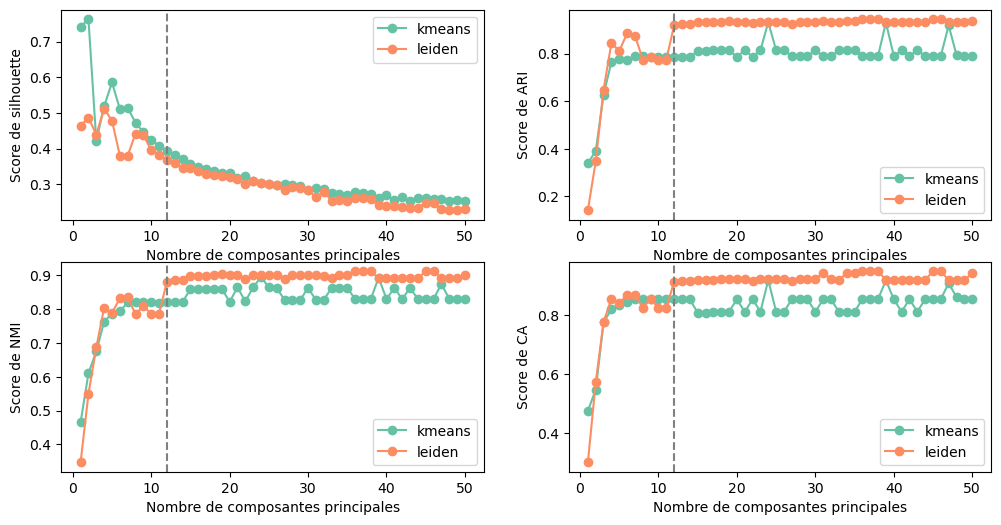

In [34]:
# plot the metric scores 
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
palette = sns.color_palette('Set2')
# flatten the axis matrix
axes = axes.flatten()
axes[0].plot(range_n_components, silhouette_scores_kmeans, marker='o', color=palette[0], label='kmeans')
axes[0].plot(range_n_components, silhouette_scores_leiden, marker='o', color=palette[1], label='leiden')
axes[0].axvline(x=12, linestyle='--', color='grey')
axes[0].set_xlabel('Nombre de composantes principales')
axes[0].set_ylabel('Score de silhouette')
axes[0].legend()
#axes[0].set_title('Score de silhouette pour différents nombres de composantes principales')


axes[1].plot(range_n_components, ari_score_kmeans, marker='o', color=palette[0], label='kmeans')
axes[1].plot(range_n_components, ari_score_leiden, marker='o', color=palette[1], label='leiden')
axes[1].axvline(x=12, linestyle='--', color='grey')
axes[1].set_xlabel('Nombre de composantes principales')
axes[1].set_ylabel('Score de ARI')
axes[1].legend()
#axes[1].set_title('Score de ARI pour différents nombres de composantes principales')

axes[2].plot(range_n_components, nmi_score_kmeans, marker='o', color=palette[0], label='kmeans')
axes[2].plot(range_n_components, nmi_score_leiden, marker='o', color=palette[1], label='leiden')
axes[2].axvline(x=12, linestyle='--', color='grey')
axes[2].set_xlabel('Nombre de composantes principales')
axes[2].set_ylabel('Score de NMI')
axes[2].legend()
#axes[2].set_title('Score de NMI pour différents nombres de composantes principales')

axes[3].plot(range_n_components, ca_score_kmeans, marker='o', color=palette[0], label='kmeans')
axes[3].plot(range_n_components, ca_score_leiden, marker='o', color=palette[1], label='leiden')
axes[3].axvline(x=12, linestyle='--', color='grey')
axes[3].set_xlabel('Nombre de composantes principales')
axes[3].set_ylabel('Score de CA')
axes[3].legend()
#axes[3].set_title('Score de CA pour différents nombres de composantes principales')

plt.show()

I decided to keep 12 principal components

In [43]:
sc.tl.pca(adata_train, n_comps=12)

<BarContainer object of 12 artists>

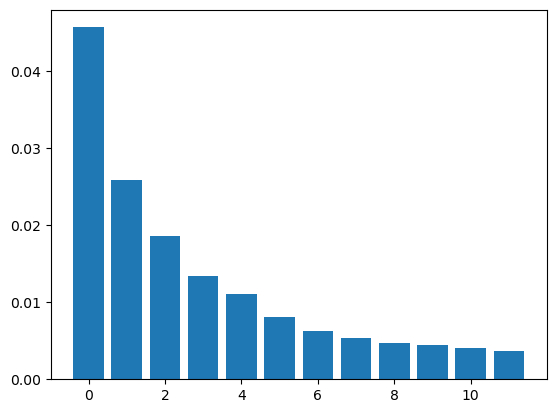

In [45]:
dim=[i for i in range (12)]
plt.bar(dim, adata_train.uns['pca']['variance_ratio'])

C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


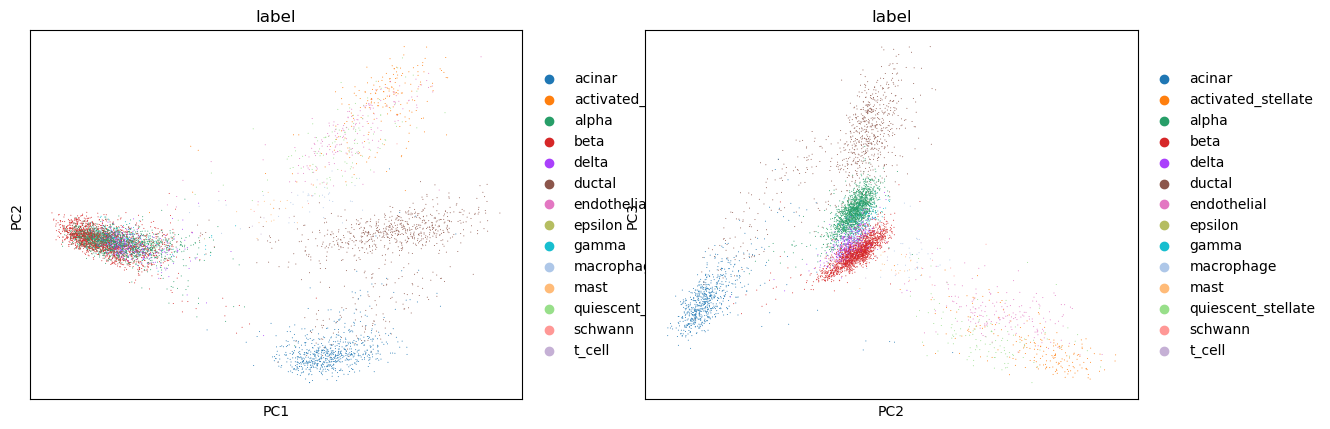

In [46]:
sc.pl.pca(
    adata_train,
    color=["label", "label"],
    dimensions=[(0, 1), (1, 2)],
    ncols=2,
    size=2,
)

We can look at the data after Leiden clustering

La résolution est de :  0.08


C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


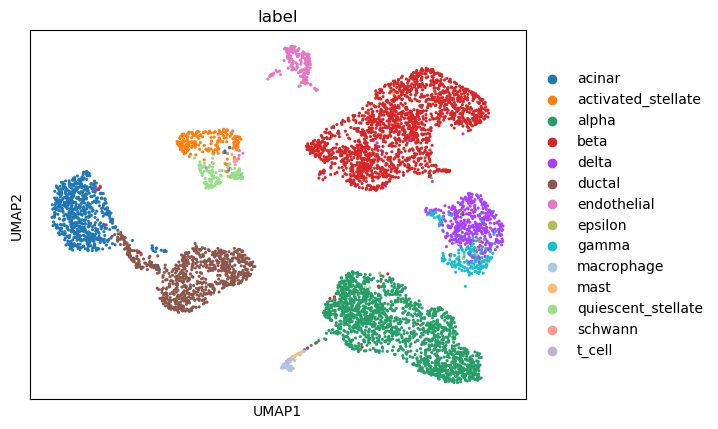

C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


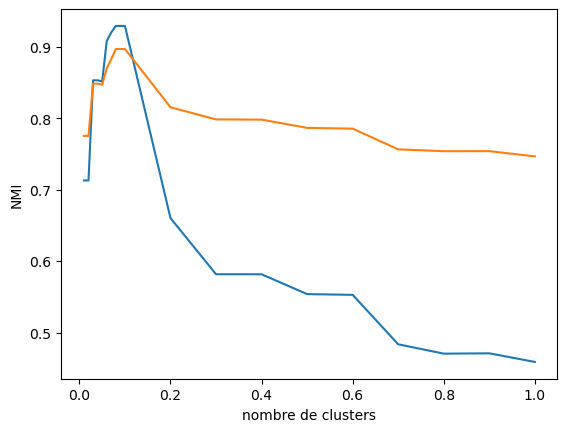

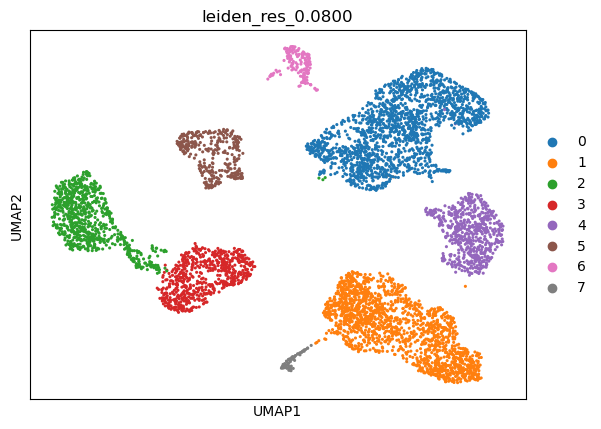

Indice de Rand ajusté (ARI) : 0.9291369413050803
Normalized mutual info (NMI) : 0.8968394625784822
Cluster Accuracy (CA) : 0.9119706568856285


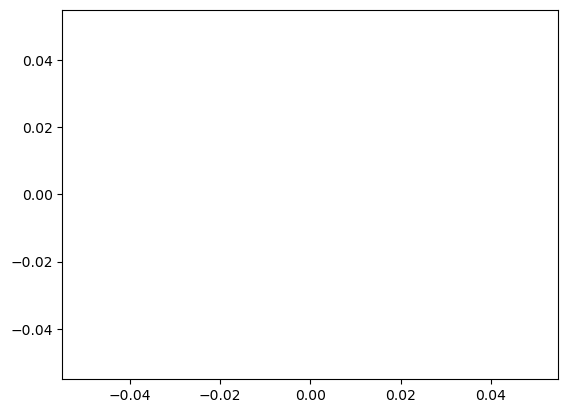

In [47]:
y_pred_train, n_clusters, cluster_centers=auto_leiden(adata_train, plot=True)

In [48]:
adata_train.obs

,label,leiden,leiden_res_0.0100,leiden_res_0.0300,leiden_res_0.0500,leiden_res_0.2000,leiden_res_0.1000,leiden_res_0.0800,leiden_res_0.0600,leiden_res_0.0700,leiden_res_0.0900
human4_lib1.final_cell_0162,alpha,9,1,0,0,1,1,1,1,1,1
human1_lib1.final_cell_0413,acinar,1,3,3,2,2,2,2,2,2,2
human3_lib2.final_cell_0295,alpha,0,0,1,0,1,1,1,1,1,1
human3_lib4.final_cell_0511,alpha,0,3,1,0,1,1,1,1,1,1
human1_lib1.final_cell_0124,beta,4,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
human3_lib4.final_cell_0298,beta,6,0,1,1,0,0,0,0,0,0
human1_lib2.final_cell_0325,beta,15,2,1,1,0,0,0,0,0,0
human2_lib2.final_cell_0058,beta,3,1,0,1,0,0,0,0,0,0
human4_lib3.final_cell_0242,alpha,9,2,1,0,1,1,1,1,1,1


Using the PCA on the train set to project the val set in the same space

In [49]:
adata_val.obsm['X_pca'] = adata_val.X @ adata_train.varm['PCs']

C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


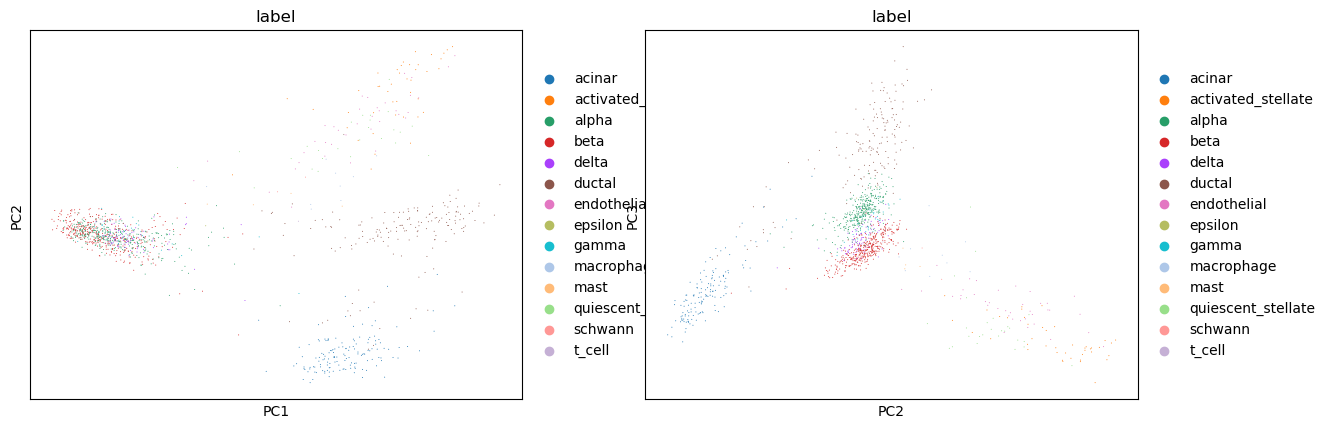

In [50]:
sc.pl.pca(
    adata_val,
    color=["label", "label"],
    dimensions=[(0, 1), (1, 2)],
    ncols=2,
    size=2,
)

Assign the validation data to the predicted clusters on the train set

In [51]:
X_val_pca = adata_val.obsm['X_pca']
distances = euclidean_distances(X_val_pca, cluster_centers)
val_clusters = np.argmin(distances, axis=1)
adata_val.obs['leiden']=val_clusters

In [52]:
cluster_centers.shape

(8, 12)

In [53]:
adata_val.obs['leiden'].shape

(1285,)

C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


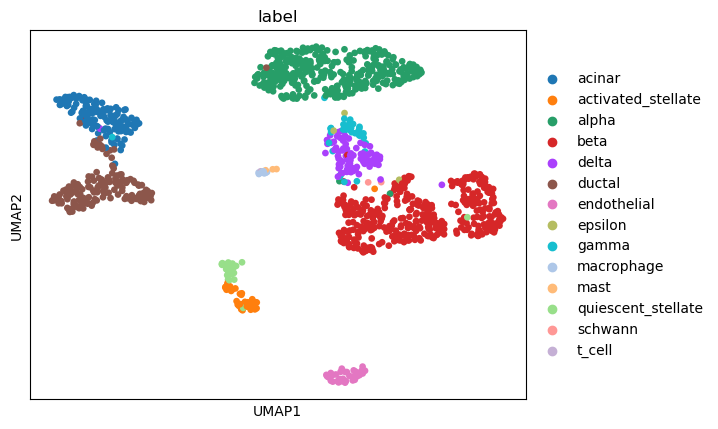

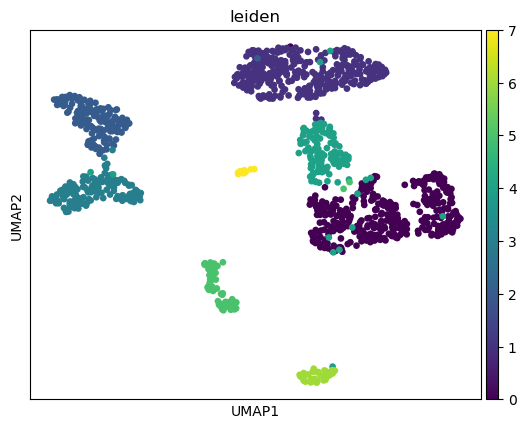

Indice de Rand ajusté (ARI) : 0.9194756449857112
Normalized mutual info (NMI) : 0.8816609013752109
Cluster Accuracy (CA) : 0.91284046692607


In [54]:
y=adata_val.obs['label']
predict=adata_val.obs["leiden"]
sc.pp.neighbors(adata_val, use_rep='X_pca')
sc.tl.umap(adata_val)
sc.pl.umap(adata_val, color='label')
sc.pl.umap( adata_val, color="leiden", legend_loc="on data")
ari = adjusted_rand_score(y, predict)
print("Indice de Rand ajusté (ARI) :", ari)
nmi = normalized_mutual_info_score(y, predict)
print("Normalized mutual info (NMI) :", nmi)
ca=cluster_acc(y, predict)
print("Cluster Accuracy (CA) :", ca)

## Now we use the PCA on the train+val set and use it to make prediction on the test set

Create a train+val set and a test set (keeping the same split for train, val and test)

In [27]:
def split(x_counts, y):
    train_idx, temp_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.3, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, stratify=y[temp_idx], test_size=0.5, random_state=42)
    train_idx = np.concatenate([train_idx, val_idx])
    x_train=x_counts[train_idx]
    x_val=x_counts[val_idx]
    x_test=x_counts[test_idx]
    y_train=y[train_idx]
    y_val=y[val_idx]
    y_test=y[test_idx]
    print("Size of train set : ", x_train.shape)
    print("Size of test set : ", x_test.shape)
    return x_train, x_test, y_train, y_test

In [28]:
x_train, x_test, y_train, y_test = split(count_data_hvg, data_ann.obs['label'])

Size of train set :  (7283, 2000)
Size of test set :  (1286, 2000)


In [29]:
adata_train = sc.AnnData(x_train)
obs_train=pd.DataFrame({'label': y_train})
adata_train.obs=obs_train
adata_train

AnnData object with n_obs × n_vars = 7283 × 2000
    obs: 'label'

In [30]:
adata_test = sc.AnnData(x_test)
obs_test=pd.DataFrame({'label': y_test})
adata_test.obs=obs_test
adata_test

AnnData object with n_obs × n_vars = 1286 × 2000
    obs: 'label'

Apply PCA and Leiden clustering on the train+val set

In [57]:
sc.tl.pca(adata_train, n_comps=12)

<BarContainer object of 12 artists>

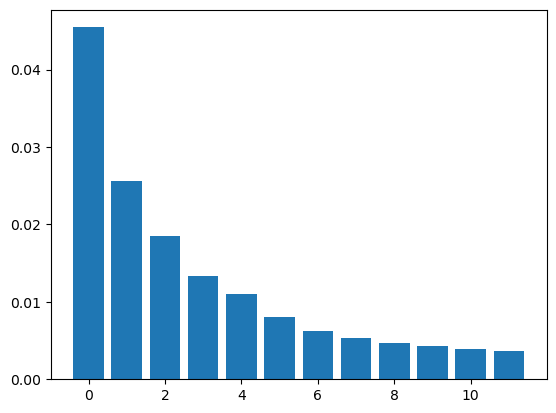

In [58]:
dim=[i for i in range (12)]
plt.bar(dim, adata_train.uns['pca']['variance_ratio'])

C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


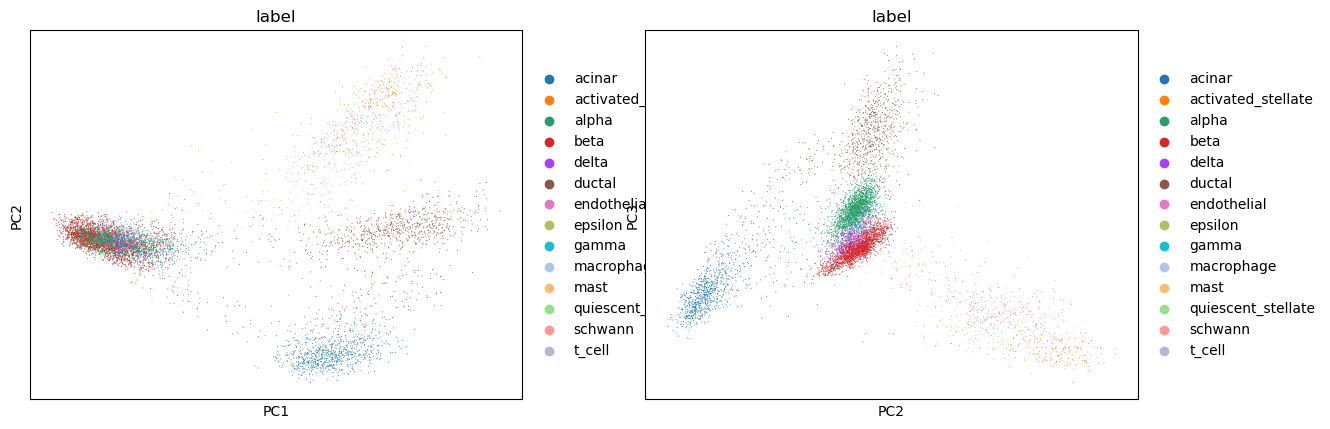

In [59]:
sc.pl.pca(
    adata_train,
    color=["label", "label"],
    dimensions=[(0, 1), (1, 2)],
    ncols=2,
    size=2,
)

La résolution est de :  0.06


C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


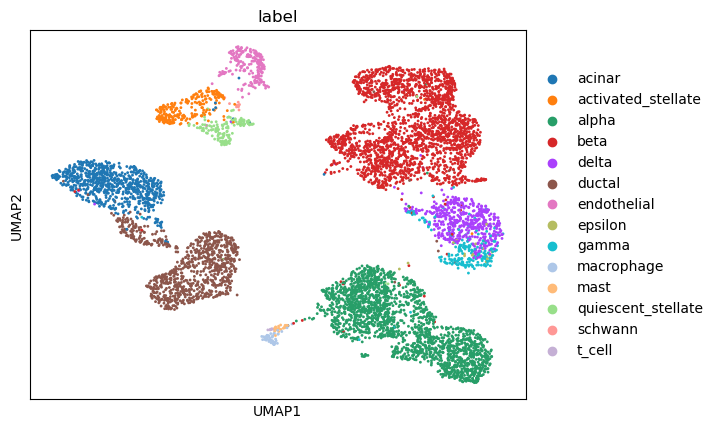

C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


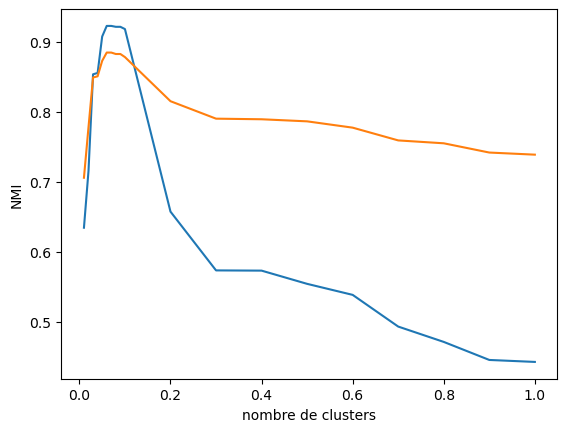

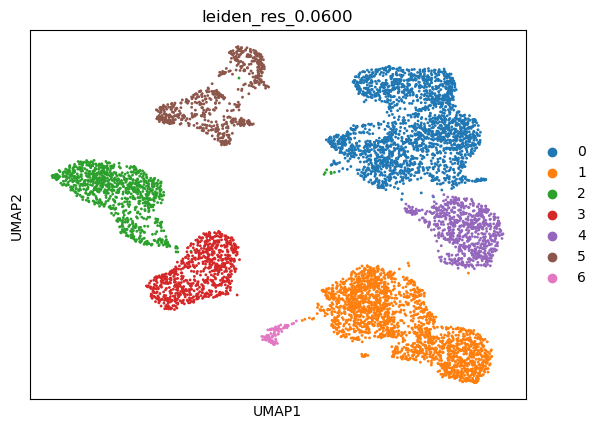

Indice de Rand ajusté (ARI) : 0.923092994895774
Normalized mutual info (NMI) : 0.8850022512013999
Cluster Accuracy (CA) : 0.8852121378552794


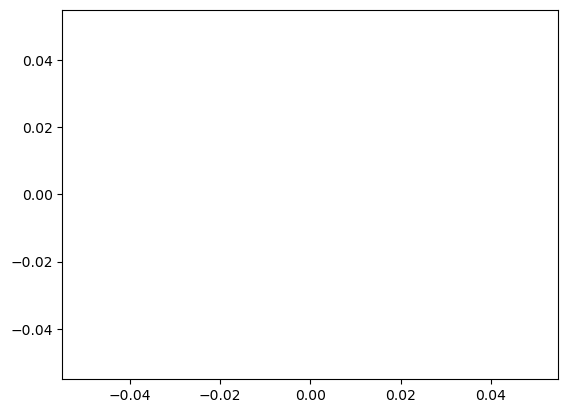

In [60]:
y_pred_train, n_clusters, cluster_centers=auto_leiden(adata_train, plot=True)

Use the PCA coordinates established on the train+val set to project the test set in the same space

In [61]:
adata_test.obsm['X_pca'] = adata_test.X @ adata_train.varm['PCs']

C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


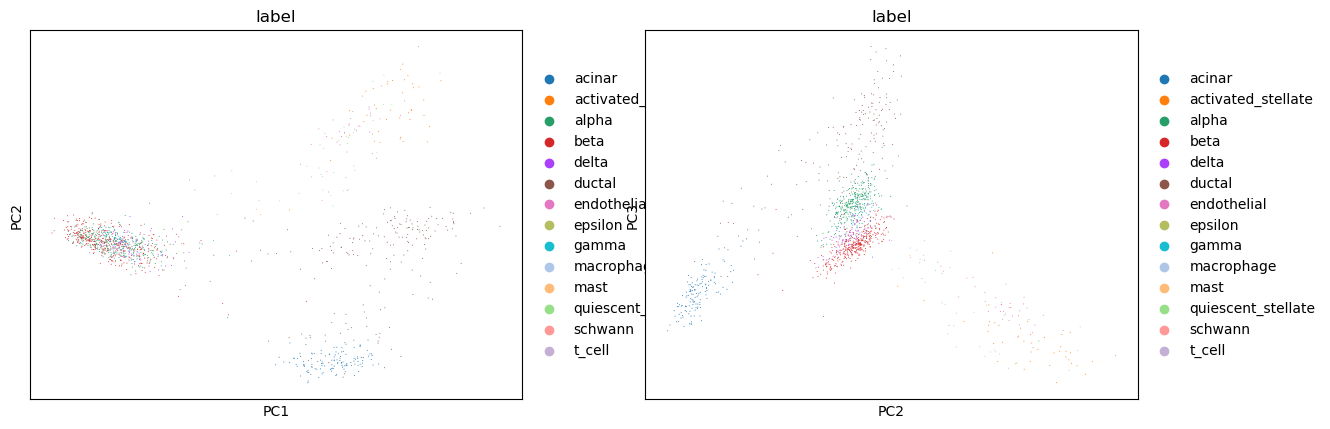

In [62]:
sc.pl.pca(
    adata_test,
    color=["label", "label"],
    dimensions=[(0, 1), (1, 2)],
    ncols=2,
    size=2,
)

Assign the test data points to the pre established clusters

In [72]:
X_test_pca = adata_test.obsm['X_pca']
distances = euclidean_distances(X_test_pca, cluster_centers)
test_clusters = np.argmin(distances, axis=1)
adata_test.obs['leiden']=test_clusters.astype(str)

In [73]:
cluster_centers.shape

(7, 12)

In [74]:
adata_train.obs['leiden'].shape

(7283,)

Evaluate

C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


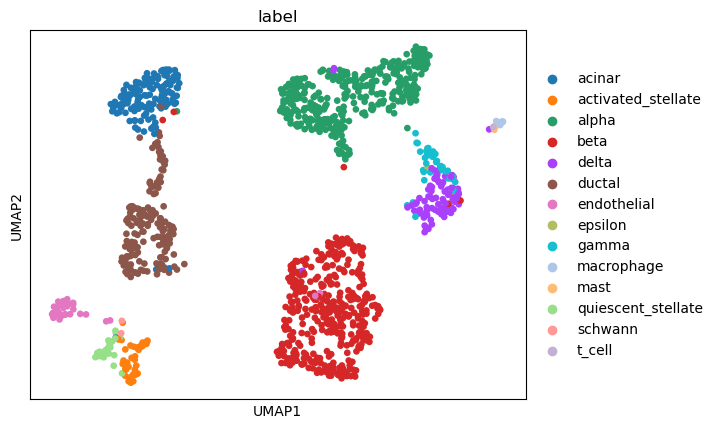

C:\Users\berth\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


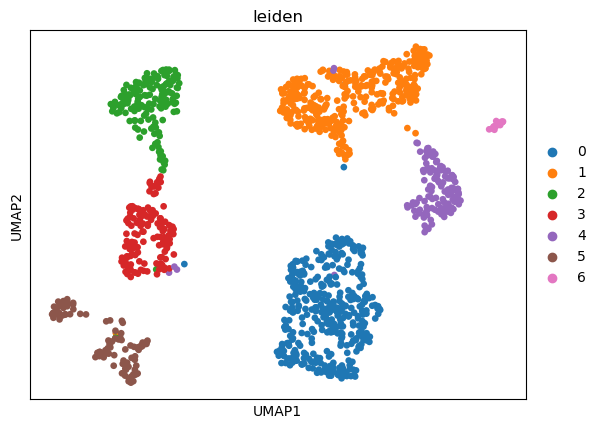

Indice de Rand ajusté (ARI) : 0.9191647496339405
Normalized mutual info (NMI) : 0.8795043186429072
Cluster Accuracy (CA) : 0.8872472783825817


In [76]:
y=adata_test.obs['label']
predict=adata_test.obs["leiden"]
sc.pp.neighbors(adata_test, use_rep='X_pca')
sc.tl.umap(adata_test)
sc.pl.umap(adata_test, color='label')
sc.pl.umap( adata_test, color="leiden")
ari = adjusted_rand_score(y, predict)
print("Indice de Rand ajusté (ARI) :", ari)
nmi = normalized_mutual_info_score(y, predict)
print("Normalized mutual info (NMI) :", nmi)
ca=cluster_acc(y, predict)
print("Cluster Accuracy (CA) :", ca)